# 1. Setup and Loading Data

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
tf.__version__
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import random

In [3]:
# Importing Quick, Draw category dataset from Google Drive (Category - Butterfly)
from google.colab import drive


In [4]:
drive.mount('/content/gdrive/') 

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
datapath1 = '/content/gdrive/My Drive/datasets/full_numpy_bitmap_butterfly.npy'
datapath2 = '/content/gdrive/My Drive/datasets/full_numpy_bitmap_aircraft carrier.npy'
datapath3 = '/content/gdrive/My Drive/datasets/full_numpy_bitmap_castle.npy'

train_data = np.load(datapath1)

In [6]:
# Exploring the training data
print(train_data.shape) #checking shape of data
print(train_data.ndim) #checking dim of data
print(train_data.size) #checking size of data
print(train_data.dtype)
new = np.ndarray((117999,28,28), np.int)
print(new.shape)
#print(new[0])

(117999, 784)
2
92511216
uint8
(117999, 28, 28)


# 2. Preprocessing the Data

(117999, 28, 28)
float32


Text(0.5, 1.0, 'Image from the dataset')

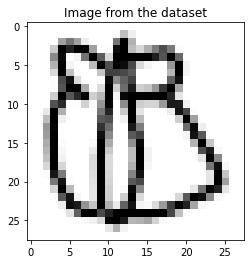

In [7]:
# Preprocessing
# array of training images + reshaping data (from (784,) to (28,28))
train_data_imgs = np.ndarray((train_data.shape[0], 28, 28), np.float32) 
for i in range(train_data.shape[0]):
  train_data_imgs[i] = np.reshape(train_data[i], (28,28))
print(train_data_imgs.shape)
print(train_data_imgs.dtype)
plt.imshow(train_data_imgs[2], cmap='Greys')
plt.title('Image from the dataset')

# 3. Model Building and Training

In [8]:
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Dropout, Input, Activation, MaxPooling2D, Reshape, UpSampling2D

Using TensorFlow backend.


Using a series of convolution and Max Pooling layers to build a simple CNN model with batch normalization practiced to normalize data.

In [9]:
# Discriminator Architecture
def discriminator(shape_in):
  input_d = Input(shape = shape_in)
  x = Conv2D(32, (3, 3))(input_d)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)
  x = Flatten()(x)
  x = Dense(128, activation = 'relu')(x)
  out_d = Dense(1, activation = 'sigmoid')(x)
  return Model(inputs = input_d, outputs = out_d)

dis = discriminator((28, 28, 1)) 

print(dis.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
___________________________________________

The generator model follows a sort of reverse architecture of a CNN (like deconvolution or transpose convolution studied in lectures) that takes a code vector as an input and using reshaping, convolution and upsampling layers, produces an image output.

In [10]:
# Generator Architecture

latent_d = 100  #vary this size, how does it affect model?

def generator(latent_d):
  input_g = Input(shape = (latent_d,))
  x = Dense(3136, activation = 'relu')(input_g)
  x = Reshape((7, 7, 64))(x)
  x = UpSampling2D()(x)
  x = Conv2D(64, (3, 3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = UpSampling2D()(x)
  x = Conv2D(32, (3, 3), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(1, (3, 3), padding = 'same')(x)
  x = BatchNormalization()(x)
  out_g = Activation('sigmoid')(x)
  return Model(inputs = input_g, outputs = out_g)

gen = generator(latent_d)
print(gen.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              316736    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 64)        0   

(1, 100)

(28, 28)


Text(0.5, 1.0, 'Randomly generated image using generator')

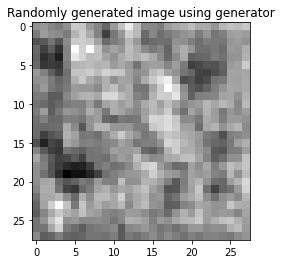

In [11]:
# Checking Generator
a = np.random.normal(size = (1, 100))
#print(a)
print(a.shape)

b = gen.predict(a)
print(b[0,:,:,0].shape)
#print(b[0,:,:,0])
plt.imshow(b[0,:,:,0], cmap='gray')
plt.title('Randomly generated image using generator')


In [12]:
# Compiling discrimnator and then building and compiling GAN

dis.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

dis.trainable = False # halting training after compiling the model (for future instances of the discrimnator)

# Define GAN
model_in = Input(shape = (latent_d,))
mid = gen(model_in)
model_out = dis(mid)

gan = Model(inputs = model_in, outputs = model_out)
print(gan.summary())

# Compile GAN
gan.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         372805    
_________________________________________________________________
model_1 (Model)              (None, 1)                 224257    
Total params: 597,062
Trainable params: 372,611
Non-trainable params: 224,451
_________________________________________________________________
None


In [13]:
# Function for Training Discriminator

def train_discriminator(train_data_imgs, batch_size, latent_d):                     #latent_d taken as input to generate fake images using generator
  ids = [random.randint(0, train_data_imgs.shape[0] - 1) for i in range(batch_size)]
  real_images = train_data_imgs[ids]
  real_target_vector = np.ones((batch_size, 1))

  fake_vector = np.random.normal(size = (batch_size, latent_d))
  fake_images = gen.predict(fake_vector)
  fake_target_vector = np.zeros((batch_size, 1))

  dis.train_on_batch(real_images, real_target_vector)
  dis.train_on_batch(fake_images, fake_target_vector)


# Function for Training Generator

def train_generator(batch_size, latent_d):
  code_vectors = np.random.normal(size = (batch_size, latent_d))
  target = np.ones((batch_size, 1))
  gan.train_on_batch(code_vectors, target)

def generate_using_generator(no_of_images, latent_d):
  fake_vector = np.random.normal(size = (no_of_images, latent_d))
  fake_images = gen.predict(fake_vector)
  # np.hstack joins images horizontally
  return np.hstack(fake_images)

In [14]:
print(train_data_imgs.shape[0])
train_data_imgs = train_data_imgs / 255.0
train_data_imgs = train_data_imgs.reshape((train_data_imgs.shape[0], 28, 28, 1))

117999


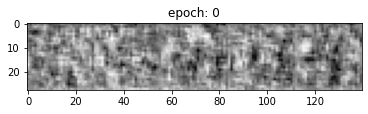

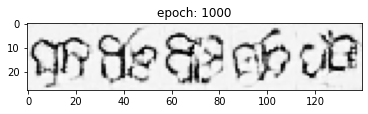

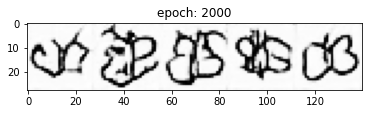

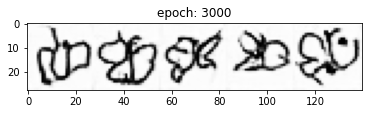

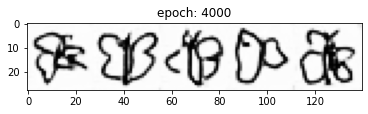

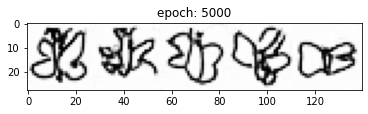

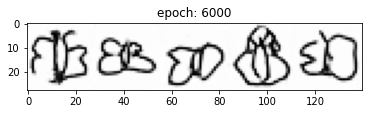

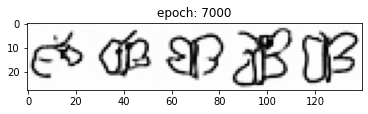

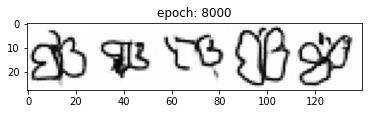

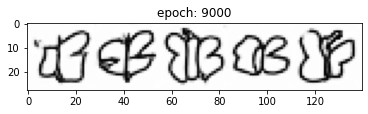

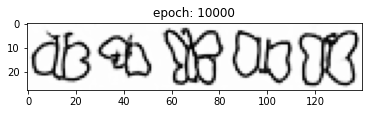

In [15]:
epochs = 11000
batch_size = 32

for i in range(epochs):
  train_discriminator(train_data_imgs, batch_size, latent_d)
  train_generator(batch_size, latent_d)

  if i % 1000 == 0:
    res = generate_using_generator(5, latent_d)
    plt.figure()
    plt.imshow(res[:,:,0], cmap = 'Greys')
    plt.title("epoch: " + str(i))
    plt.show()

# 4. Function to Generate n Images

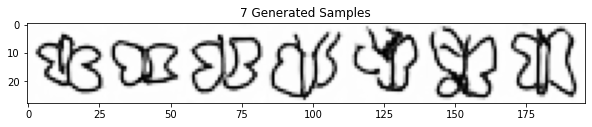

In [16]:
# This function is developed based on the following function defined previously:
# def generate_using_generator(no_of_images, latent_d):
#   fake_vector = np.random.normal(size = (no_of_images, latent_d))
#   fake_images = gen.predict(fake_vector)
#   return np.hstack(fake_images)

def generate_samples(n, latent_d):
  generator = generate_using_generator(n, latent_d)
  plt.figure(figsize = (10, 20))
  plt.imshow(generator[:,:,0], cmap = 'Greys')
  plt.title(str(n) + ' Generated Samples')

generate_samples(7, latent_d)

# Plotting the Losses

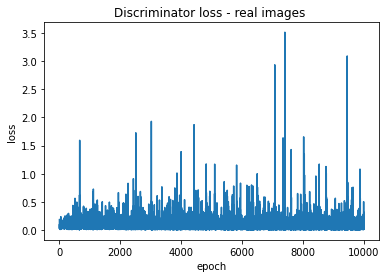

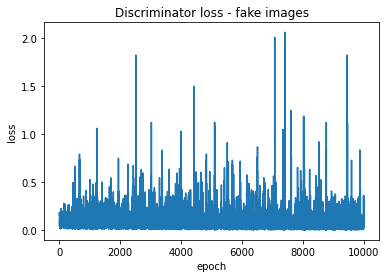

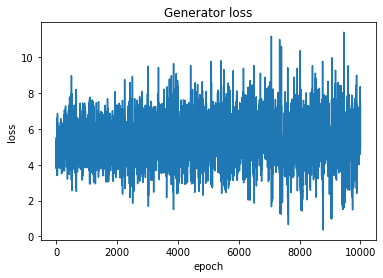

In [17]:
# Function for Training Discriminator
def train_discriminator(train_data_imgs, batch_size, latent_d):                     #latent_d taken as input to generate fake images using generator
  ids = [random.randint(0, train_data_imgs.shape[0] - 1) for i in range(batch_size)]
  real_images = train_data_imgs[ids]
  real_target_vector = np.ones((batch_size, 1))

  fake_vector = np.random.normal(size = (batch_size, latent_d))
  fake_images = gen.predict(fake_vector)
  fake_target_vector = np.zeros((batch_size, 1))

  loss_dr = dis.train_on_batch(real_images, real_target_vector)
  loss_df = dis.train_on_batch(fake_images, fake_target_vector)

  return loss_dr, loss_df


# Function for Training Generator
def train_generator(batch_size, latent_d):
  code_vectors = np.random.normal(size = (batch_size, latent_d))
  target = np.ones((batch_size, 1))
  loss_g = gan.train_on_batch(code_vectors, target)

  return loss_g

epochs = 10000
batch_size = 128
loss_disc_real = list()
loss_disc_fake = list()
loss_gen = list()

for i in range(epochs):
  loss_dr, loss_df = train_discriminator(train_data_imgs, batch_size, latent_d)
  loss_g = train_generator(batch_size, latent_d)

  loss_disc_real.append(loss_dr[0])
  loss_disc_fake.append(loss_df[0])
  loss_gen.append(loss_g[0])

plt.figure()
plt.plot(list(range(epochs)), loss_disc_real)
plt.title('Discriminator loss - real images ')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
plt.plot(list(range(epochs)), loss_disc_fake)
plt.title('Discriminator loss - fake images')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
plt.plot(list(range(epochs)), loss_gen)
plt.title('Generator loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()


The loss results for GANS are often not intuitive. There appears to be no particular pattern to them but that is perhaps due to the nature of the competing discriminator and generator. Making the model better by tweaking hyperparameters may yield some pattern though and on some other runs with this training process, by changing the batch size and number of epochs, it was sometimes the case that some observable convergence pattern was observed where the loss would more or less settle at some value. For instance, the following plot was obtained in one of the trail runs perfromed which seems to exhibit a convergence. 

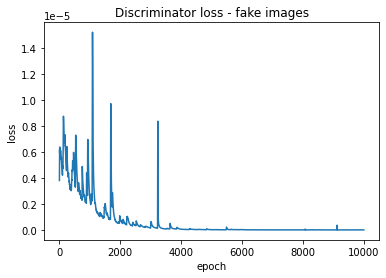

However, largely, the plots of the losses yield results which do not exhibit a particular discernable pattern.


# Archived Result for Higher No. of Epochs

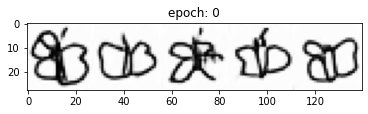

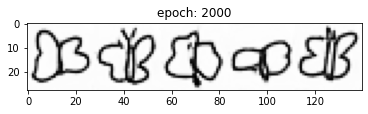

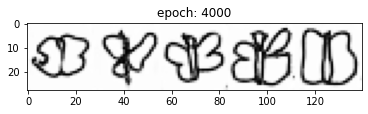

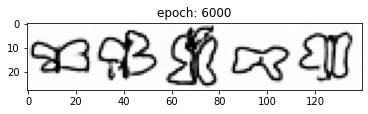

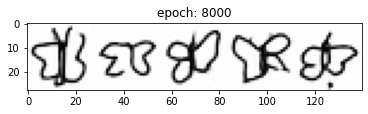

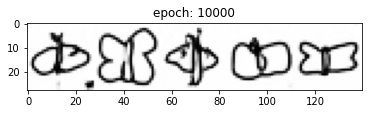

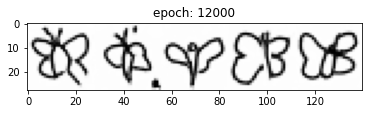

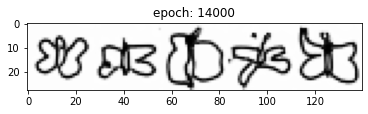

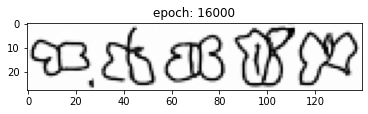

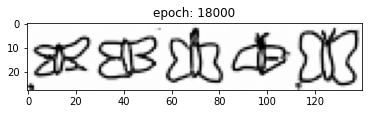

In [ ]:
epochs = 20000
batch_size = 32

for i in range(epochs):
  train_discriminator(train_data_imgs, batch_size, latent_d)
  train_generator(batch_size, latent_d)
  if i % 2000 == 0:
    res = generate_using_generator(5, latent_d)
    plt.figure()
    plt.imshow(res[:,:,0], cmap = 'Greys')
    plt.title("epoch: " + str(i))
    plt.show()